In [1]:
%matplotlib inline

import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from datetime import datetime
from jtwc import load_jtwc_data



In [2]:
input_path = r"X:\georisk\HaRIA_B_Wind\data\raw\from_jtwc\bsh"
output_path = r"X:\georisk\HaRIA_B_Wind\projects\tcha\data\derived\windradii"

In [3]:
df = load_jtwc_data(input_path)

Skipping line 8: expected 35 fields, saw 38

Skipping line 9: expected 35 fields, saw 38

Skipping line 8: expected 35 fields, saw 38
Skipping line 9: expected 35 fields, saw 40

Skipping line 6: expected 35 fields, saw 38

Skipping line 8: expected 35 fields, saw 38

Skipping line 9: expected 35 fields, saw 38

Skipping line 4: expected 35 fields, saw 38
Skipping line 8: expected 35 fields, saw 38
Skipping line 10: expected 35 fields, saw 38

Skipping line 13: expected 35 fields, saw 38

Skipping line 12: expected 35 fields, saw 38

Skipping line 6: expected 35 fields, saw 38

Skipping line 8: expected 35 fields, saw 38
Skipping line 9: expected 35 fields, saw 38

Skipping line 6: expected 35 fields, saw 38

Skipping line 7: expected 35 fields, saw 38

Skipping line 31: expected 35 fields, saw 38
Skipping line 35: expected 35 fields, saw 38
Skipping line 39: expected 35 fields, saw 38
Skipping line 43: expected 35 fields, saw 38
Skipping line 44: expected 35 fields, saw 38

Skipping l

Set up the predictors and predictand. We choose the absolute value of the latitude so that conceptually the model is independent of the hemisphere. The model is defined as $ln(R_{mw}) = \alpha + \beta_0 \Delta p + \beta_1 |\lambda| + \epsilon$, where $\epsilon$ is an error term.

In [4]:
mask = ~np.isnan(df.r34.values)
X = np.column_stack((df.dP.values[mask], np.abs(df.Latitude.values[mask])))
y = np.log(df.rMax.values[mask])

We set up the model with fairly uninformative priors - all parameters are initialised with a normal distribution with zero mean. The intercept ($\alpha$) is given a broader distribution ($\sigma=10$), while the coefficients for $\Delta p$ and $\lambda$ are chosen to have unit variance. 

In the code below, we specify a prior for the magnitude of the variance of the error term $\epsilon$ - this means we can estimate the variance $\sigma^2$ to use in a $\mathcal{N}(0,\,\sigma^{2})$ distribution.

In [5]:
with pm.Model() as rmaxmodel:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    mu = alpha + beta[0] * X[:, 0] + beta[1] * X[:, 1]
    epsilon = pm.HalfNormal("epsilon", sigma=1)
    y_hat = pm.Normal('y_hat', mu=mu, sigma=epsilon, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=True)
    trace.extend(pm.sample_posterior_predictive(trace))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [epsilon]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 69 seconds.
Sampling: [y_hat]


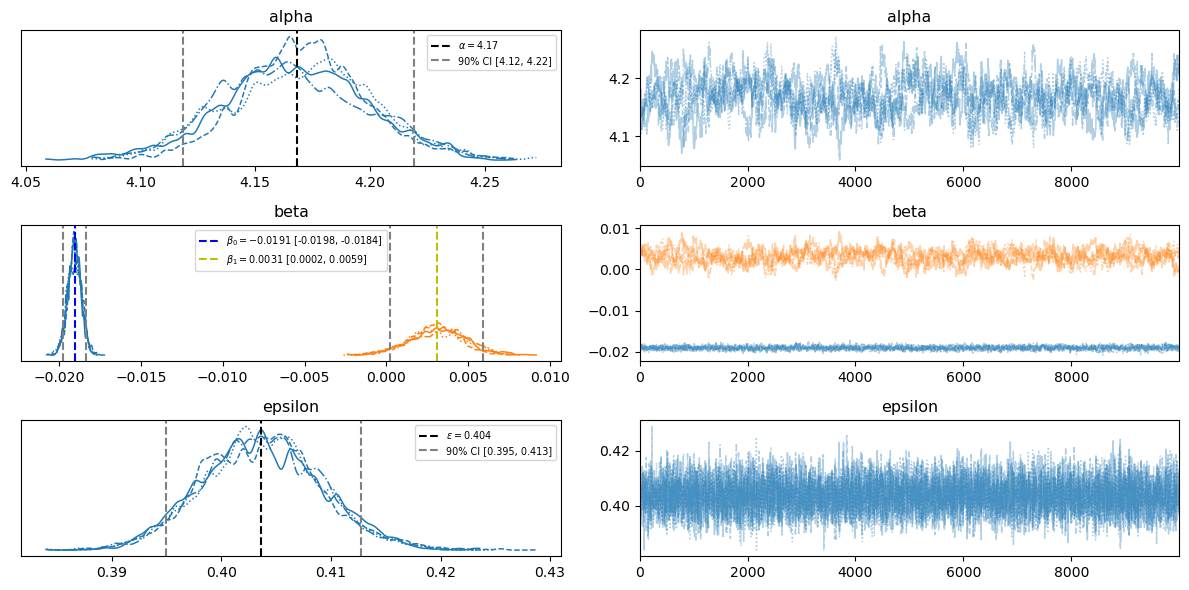

In [6]:
axes = az.plot_trace(trace, combined=False)
aq = np.quantile(trace.posterior['alpha'], [0.05, 0.5, 0.95])
bq = np.quantile(trace.posterior['beta'], [0.05, 0.5, 0.95], axis=(0, 1))
eq = np.quantile(trace.posterior['epsilon'], [0.05, 0.5, 0.95])

axes[0, 0].axvline(aq[1], ls='--', color='k', label=rf'$\alpha = {{{aq[1]:.2f}}}$')
axes[0, 0].axvline(aq[0], ls='--', color='gray', label=f"90% CI [{aq[0]:.2f}, {aq[2]:.2f}]")
axes[0, 0].axvline(aq[2], ls='--', color='gray')

axes[1, 0].axvline(bq[1, 0], ls='--', color='b', label=rf'$\beta_0 = {{{bq[1, 0]:.4f}}}$ [{bq[0, 0]:.4f}, {bq[2, 0]:.4f}]')
axes[1, 0].axvline(bq[0, 0], ls='--', color='gray',)
axes[1, 0].axvline(bq[2, 0], ls='--', color='gray')

axes[1, 0].axvline(bq[1, 1], ls='--', color='y', label=rf'$\beta_1 = {{{bq[1, 1]:.4f}}}$ [{bq[0, 1]:.4f}, {bq[2, 1]:.4f}]')
axes[1, 0].axvline(bq[0, 1], ls='--', color='gray',)
axes[1, 0].axvline(bq[2, 1], ls='--', color='gray')

axes[2, 0].axvline(eq[1], ls='--', color='k', label=rf'$\epsilon = {{{eq[1]:.3f}}}$')
axes[2, 0].axvline(eq[0], ls='--', color='gray', label=f"90% CI [{eq[0]:.3f}, {eq[2]:.3f}]")
axes[2, 0].axvline(eq[2], ls='--', color='gray')

axes[0, 0].legend(fontsize='x-small')
axes[1, 0].legend(fontsize='x-small')
axes[2, 0].legend(fontsize='x-small')
plt.tight_layout()

In [7]:
az.summary(trace, round_to=4, hdi_prob=0.9,)#[['mean', 'sd', 'hdi_5%', 'hdi_95%']]

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.1685,0.0306,4.1179,4.2183,0.0021,0.0015,221.5648,725.1978,1.0135
beta[0],-0.0191,0.0004,-0.0197,-0.0183,0.0000,0.0000,1598.4320,2388.8211,1.0027
beta[1],0.0031,0.0017,0.0003,0.0059,0.0001,0.0001,222.6537,687.3365,1.0143
epsilon,0.4037,0.0054,0.3950,0.4128,0.0001,0.0000,7596.1152,7585.0534,1.0008


Text(0, 0.5, '$R_{mw}$ [km]')

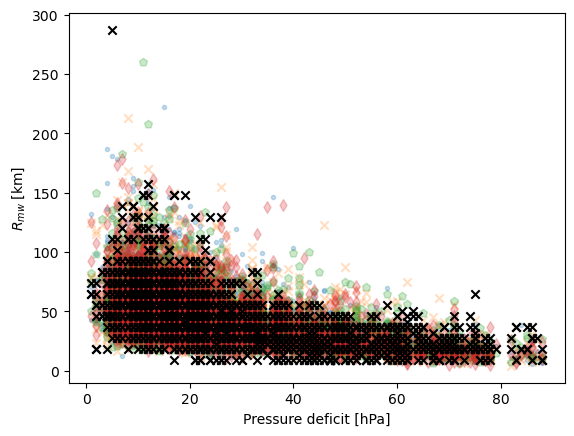

In [15]:
#trace.posterior['ymodel'] = trace.posterior['alpha'] + trace.posterior['beta'] * xr.DataArray(X) + trace.posterior['error']
plt.scatter(X[:,0], np.exp(trace.posterior_predictive['y_hat'][0, 0, :]), marker='.', alpha=0.25)
plt.scatter(X[:,0], np.exp(trace.posterior_predictive['y_hat'][1, 0, :]), marker='x', alpha=0.25)
plt.scatter(X[:,0], np.exp(trace.posterior_predictive['y_hat'][2, 0, :]), marker='p', alpha=0.25)
plt.scatter(X[:,0], np.exp(trace.posterior_predictive['y_hat'][3, 0, :]), marker='d', alpha=0.25)
plt.scatter(X[:, 0], np.exp(y), marker='x', c='k')
plt.xlabel("Pressure deficit [hPa]")
plt.ylabel(r"$R_{mw}$ [km]")

Text(0, 0.5, '$R_{mw}$ [km]')

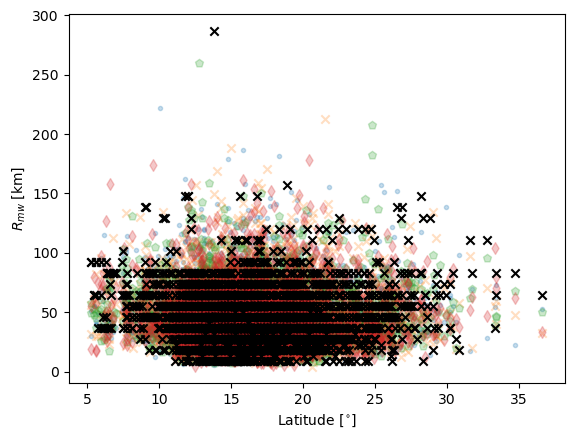

In [16]:
plt.scatter(X[:, 1], np.exp(trace.posterior_predictive['y_hat'][0, 0, :]), marker='.', alpha=0.25)
plt.scatter(X[:, 1], np.exp(trace.posterior_predictive['y_hat'][1, 0, :]), marker='x', alpha=0.25)
plt.scatter(X[:, 1], np.exp(trace.posterior_predictive['y_hat'][2, 0, :]), marker='p', alpha=0.25)
plt.scatter(X[:, 1], np.exp(trace.posterior_predictive['y_hat'][3, 0, :]), marker='d', alpha=0.25)
plt.scatter(X[:, 1], np.exp(y), marker='x', c='k')
plt.xlabel(r"Latitude [$^{\circ}$]")
plt.ylabel(r"$R_{mw}$ [km]")